## Setup

In [1]:
%pip install torch torchvision matplotlib scikit-learn seaborn pandas

Note: you may need to restart the kernel to use updated packages.


### Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.models import alexnet, AlexNet_Weights
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

### Global Constants

In [4]:
# Set random seed for reproducibility
torch.manual_seed(0)

# Maps the labels to the class names
labelsMap = {
    0: "Bedroom",
    1: "Coast",
    2: "Forest",
    3: "Highway",
    4: "Industrial",
    5: "InsideCity",
    6: "Kitchen",
    7: "LivingRoom",
    8: "Mountain",
    9: "Office",
    10: "OpenCountry",
    11: "Store",
    12: "Street",
    13: "Suburb",
    14: "TallBuilding"
}

BATCH_SIZE = 32

EPOCHS = 30

transforms_pipeline = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x*255),
])

## Loading the dataset

In [5]:
train_dataset = datasets.ImageFolder("./dataset/train", transform=transforms_pipeline)

test_dataset = datasets.ImageFolder("./dataset/test", transform=transforms_pipeline)

train_dataset,  val_dataset = random_split(train_dataset, [int(len(train_dataset)*0.85), int(len(train_dataset)*0.15)])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Train dataset size: 1275
Validation dataset size: 225
Test dataset size: 2985


## Data Augmentation

In [6]:
augmented_transforms_pipeline = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x*255),
])

augmented_train_dataset = datasets.ImageFolder("./dataset/train", transform=augmented_transforms_pipeline)

augmented_train_dataset,  _ = random_split(augmented_train_dataset, [int(len(augmented_train_dataset)*0.85), int(len(augmented_train_dataset)*0.15)])

augmented_train_loader = DataLoader(augmented_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Augmented Train dataset size: {len(augmented_train_dataset)}")

Augmented Train dataset size: 1275


## Define Neural Networks

### Baseline Custom Neural Network

In [9]:
class Baseline(nn.Module):

    def __init__(self):
        super(Baseline, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.fc = nn.Linear(in_features=32*16*16, out_features=15)
        self.apply(self._init_weights)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = x.view(-1, 32 * 16 * 16)
        x = self.fc(x)
        return x
    
    def _init_weights(self, module):
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.01)
            nn.init.zeros_(module.bias)

### Baseline with Batch normalization

In [10]:
class BaselineBatch(Baseline):
    
    def __init__(self):
        super(BaselineBatch, self).__init__()
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.batchnorm2 = nn.BatchNorm2d(16)
        self.batchnorm3 = nn.BatchNorm2d(32)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.relu3(x)
        x = x.view(-1, 32 * 16 * 16)
        x = self.fc(x)
        return x

### Baseline with different Kernel size

In [11]:
class BaselineKernels(Baseline):
    
    def __init__(self):
        super(BaselineKernels, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=7, stride=1, padding=1)
        self.fc = nn.Linear(in_features=32*11*11, out_features=15)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = x.view(-1, 32 * 11 * 11)
        x = self.fc(x)
        return x


### Baseline with Dropout

In [45]:
class BaselineDropout(Baseline):

    def __init__(self):
        super(BaselineDropout, self).__init__()
        self.dropout = nn.Dropout(p=0.5)


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = x.view(-1, 32 * 16 * 16)
        x = self.fc(x)
        return x

## Define Training Loop

In [14]:
def train_one_epoch(model, loss_fn, optimizer, train_loader):
    model.train()
    running_loss = 0.0
    for i, (input, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(input)
        loss = loss_fn(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    return running_loss / (i + 1)

def training(model, loss_fn, optimizer, train_loader, val_loader, epochs, name):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        train_loss = train_one_epoch(model, loss_fn, optimizer, train_loader)
        
        runnining_val_loss = 0.0

        model.eval()
        with torch.no_grad():
            for i, (input, labels) in enumerate(val_loader):
                outputs = model(input)
                loss = loss_fn(outputs, labels)
                runnining_val_loss += loss.item()
        val_loss = runnining_val_loss / (i + 1)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Train Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"./models/{name}.pth")
    
    plt.plot(train_losses, color='g', label="Training Loss")
    plt.plot(val_losses, color='r',label="Validation Loss")

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


## Define Testing Loop

In [18]:
def test(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for (input, labels) in test_loader:
            outputs = model(input)
            _, predicted = torch.max(outputs, 1)
            y_true += labels.tolist()
            y_pred += predicted.tolist()
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm / np.sum(cm, axis=1)[:, None], index = [labelsMap[i] for i in range(15)], columns = [labelsMap[i] for i in range(15)])
    plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Test Accuracy: {np.mean(np.array(y_true) == np.array(y_pred))*100:.2f}%')
    plt.show()

### Define Testing Loop for Ensemble of Networks

In [19]:
def test_ensemble(models, test_loader):
    y_true = []
    y_pred = []
    for model in models:
        model.eval()
    
    with torch.no_grad():
        for (input, labels) in test_loader:
            outputs = [model(input) for model in models]
            avg_output = torch.mean(torch.stack(outputs), dim=0)
            _, predicted = torch.max(avg_output, 1)
            y_true += labels.tolist()
            y_pred += predicted.tolist()
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm / np.sum(cm, axis=1)[:, None], index = [labelsMap[i] for i in range(15)], columns = [labelsMap[i] for i in range(15)])
    plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Test Accuracy: {np.mean(np.array(y_true) == np.array(y_pred))*100:.2f}%')
    plt.show()

## Training

### Training Baseline model

Epoch 1/30
Train Loss: 2.7075 - Validation Loss: 2.7064
Epoch 2/30
Train Loss: 2.7034 - Validation Loss: 2.6985
Epoch 3/30
Train Loss: 2.6903 - Validation Loss: 2.6293
Epoch 4/30
Train Loss: 2.6600 - Validation Loss: 2.4843
Epoch 5/30
Train Loss: 2.6035 - Validation Loss: 2.4532
Epoch 6/30
Train Loss: 2.5712 - Validation Loss: 2.3682
Epoch 7/30
Train Loss: 2.5123 - Validation Loss: 2.2983
Epoch 8/30
Train Loss: 2.4675 - Validation Loss: 2.2394
Epoch 9/30
Train Loss: 2.4050 - Validation Loss: 2.2269
Epoch 10/30
Train Loss: 2.3160 - Validation Loss: 2.2036
Epoch 11/30
Train Loss: 2.2476 - Validation Loss: 2.1576
Epoch 12/30
Train Loss: 2.1249 - Validation Loss: 2.0991
Epoch 13/30
Train Loss: 2.0067 - Validation Loss: 2.1200
Epoch 14/30
Train Loss: 1.8905 - Validation Loss: 2.2441
Epoch 15/30
Train Loss: 1.7351 - Validation Loss: 2.0957
Epoch 16/30
Train Loss: 1.5489 - Validation Loss: 2.2185
Epoch 17/30
Train Loss: 1.3169 - Validation Loss: 2.0266
Epoch 18/30
Train Loss: 1.1181 - Validat

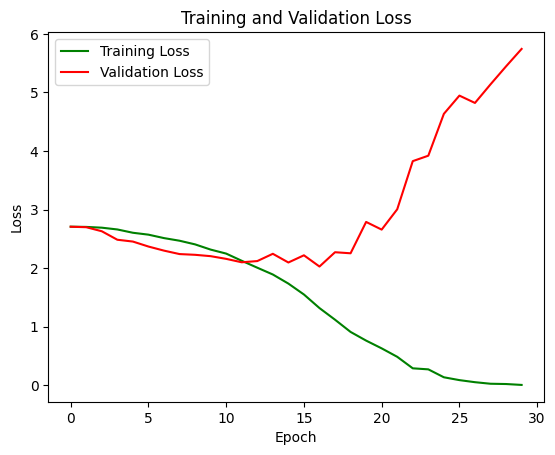

In [13]:
model = Baseline()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.75)

training(model, loss_fn, optimizer, train_loader, val_loader, epochs=EPOCHS, name="baseline")

#### Training Baseline on augmented data

Epoch 1/30
Train Loss: 2.7074 - Validation Loss: 2.6977
Epoch 2/30
Train Loss: 2.7035 - Validation Loss: 2.6684
Epoch 3/30
Train Loss: 2.6965 - Validation Loss: 2.6805
Epoch 4/30
Train Loss: 2.6822 - Validation Loss: 2.5105
Epoch 5/30
Train Loss: 2.6464 - Validation Loss: 2.4412
Epoch 6/30
Train Loss: 2.5997 - Validation Loss: 2.4310
Epoch 7/30
Train Loss: 2.5717 - Validation Loss: 2.3269
Epoch 8/30
Train Loss: 2.5264 - Validation Loss: 2.3395
Epoch 9/30
Train Loss: 2.4800 - Validation Loss: 2.2476
Epoch 10/30
Train Loss: 2.4695 - Validation Loss: 2.2952
Epoch 11/30
Train Loss: 2.3934 - Validation Loss: 2.0234
Epoch 12/30
Train Loss: 2.4024 - Validation Loss: 2.2319
Epoch 13/30
Train Loss: 2.3078 - Validation Loss: 2.4116
Epoch 14/30
Train Loss: 2.2483 - Validation Loss: 1.8103
Epoch 15/30
Train Loss: 2.1770 - Validation Loss: 2.2639
Epoch 16/30
Train Loss: 2.1856 - Validation Loss: 1.8507
Epoch 17/30
Train Loss: 2.0141 - Validation Loss: 1.7823
Epoch 18/30
Train Loss: 1.9246 - Validat

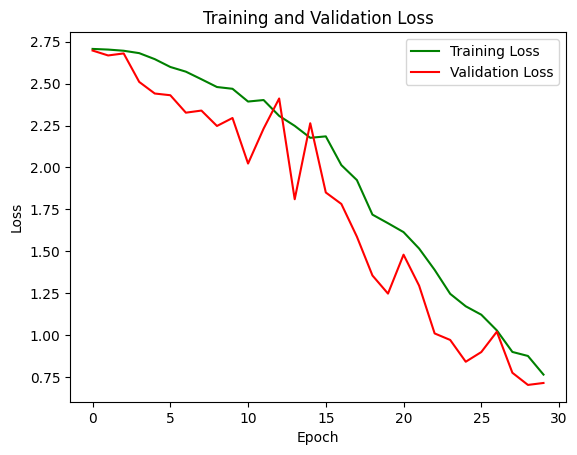

In [14]:
model = Baseline()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.75)

training(model, loss_fn, optimizer, augmented_train_loader, val_loader, epochs=EPOCHS, name="augmentedBaseline")

### Training Baseline with Batch Normalization

Epoch 1/30
Train Loss: 2.5633 - Validation Loss: 2.3500
Epoch 2/30
Train Loss: 2.0186 - Validation Loss: 2.0201
Epoch 3/30
Train Loss: 1.7066 - Validation Loss: 2.0414
Epoch 4/30
Train Loss: 1.4539 - Validation Loss: 1.8680
Epoch 5/30
Train Loss: 1.2425 - Validation Loss: 1.8125
Epoch 6/30
Train Loss: 1.0770 - Validation Loss: 1.4653
Epoch 7/30
Train Loss: 0.9508 - Validation Loss: 1.4695
Epoch 8/30
Train Loss: 0.8384 - Validation Loss: 1.3969
Epoch 9/30
Train Loss: 0.7419 - Validation Loss: 1.3969
Epoch 10/30
Train Loss: 0.6511 - Validation Loss: 1.4553
Epoch 11/30
Train Loss: 0.5816 - Validation Loss: 1.4324
Epoch 12/30
Train Loss: 0.5272 - Validation Loss: 1.4278
Epoch 13/30
Train Loss: 0.4683 - Validation Loss: 1.3057
Epoch 14/30
Train Loss: 0.4241 - Validation Loss: 1.3271
Epoch 15/30
Train Loss: 0.3845 - Validation Loss: 1.3281
Epoch 16/30
Train Loss: 0.3481 - Validation Loss: 1.3359
Epoch 17/30
Train Loss: 0.3137 - Validation Loss: 1.3796
Epoch 18/30
Train Loss: 0.2979 - Validat

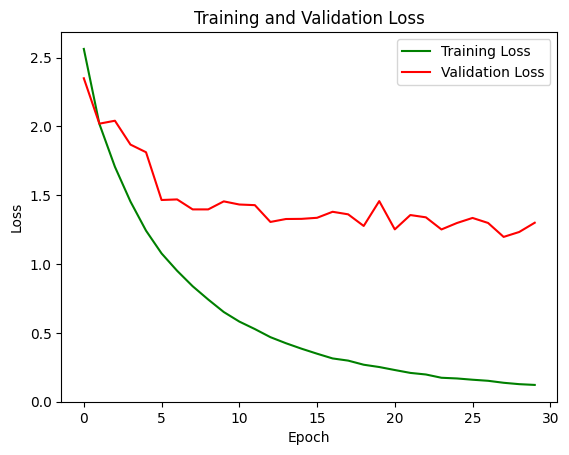

In [15]:
model = BaselineBatch()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.75)

training(model, loss_fn, optimizer, train_loader, val_loader, epochs=EPOCHS, name="batch")

#### Training Baseline with Batch Normalization on Augmented Data

Epoch 1/30
Train Loss: 2.5841 - Validation Loss: 2.2367
Epoch 2/30
Train Loss: 2.0792 - Validation Loss: 2.1089
Epoch 3/30
Train Loss: 1.7976 - Validation Loss: 1.5887
Epoch 4/30
Train Loss: 1.6669 - Validation Loss: 1.3847
Epoch 5/30
Train Loss: 1.5397 - Validation Loss: 1.4370
Epoch 6/30
Train Loss: 1.3858 - Validation Loss: 1.2477
Epoch 7/30
Train Loss: 1.2497 - Validation Loss: 3.3089
Epoch 8/30
Train Loss: 1.1486 - Validation Loss: 1.2806
Epoch 9/30
Train Loss: 1.0485 - Validation Loss: 1.0458
Epoch 10/30
Train Loss: 0.9772 - Validation Loss: 0.8996
Epoch 11/30
Train Loss: 0.8788 - Validation Loss: 3.2547
Epoch 12/30
Train Loss: 0.8774 - Validation Loss: 0.7898
Epoch 13/30
Train Loss: 0.7893 - Validation Loss: 0.7157
Epoch 14/30
Train Loss: 0.7083 - Validation Loss: 0.6607
Epoch 15/30
Train Loss: 0.6734 - Validation Loss: 1.8700
Epoch 16/30
Train Loss: 0.6272 - Validation Loss: 0.7171
Epoch 17/30
Train Loss: 0.5863 - Validation Loss: 0.7674
Epoch 18/30
Train Loss: 0.5708 - Validat

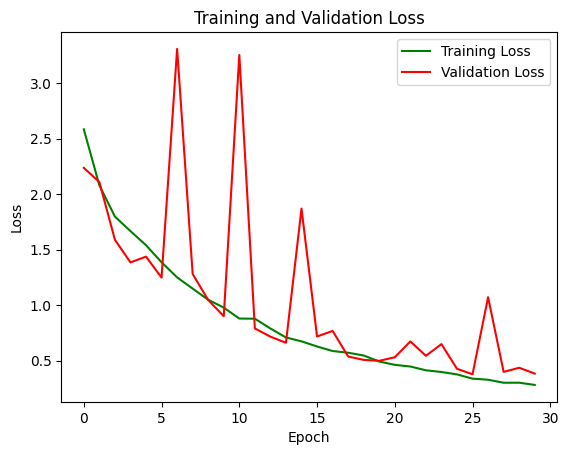

In [16]:
model = BaselineBatch()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.75)

training(model, loss_fn, optimizer, augmented_train_loader, val_loader, epochs=EPOCHS, name="augmentedBatch")

### Training Baseline with different kernel size

Epoch 1/30
Train Loss: 2.7961 - Validation Loss: 2.6278
Epoch 2/30
Train Loss: 2.5561 - Validation Loss: 2.4227
Epoch 3/30
Train Loss: 2.4319 - Validation Loss: 2.5033
Epoch 4/30
Train Loss: 2.3504 - Validation Loss: 2.4788
Epoch 5/30
Train Loss: 2.1290 - Validation Loss: 2.0026
Epoch 6/30
Train Loss: 1.8180 - Validation Loss: 1.8878
Epoch 7/30
Train Loss: 1.5543 - Validation Loss: 1.9109
Epoch 8/30
Train Loss: 1.3522 - Validation Loss: 1.6771
Epoch 9/30
Train Loss: 1.0707 - Validation Loss: 1.6918
Epoch 10/30
Train Loss: 0.7653 - Validation Loss: 2.0132
Epoch 11/30
Train Loss: 0.4728 - Validation Loss: 2.2651
Epoch 12/30
Train Loss: 0.4579 - Validation Loss: 2.3576
Epoch 13/30
Train Loss: 0.1836 - Validation Loss: 2.2500
Epoch 14/30
Train Loss: 0.1445 - Validation Loss: 2.4852
Epoch 15/30
Train Loss: 0.1012 - Validation Loss: 2.4364
Epoch 16/30
Train Loss: 0.0513 - Validation Loss: 2.4305
Epoch 17/30
Train Loss: 0.0213 - Validation Loss: 2.7360
Epoch 18/30
Train Loss: 0.0111 - Validat

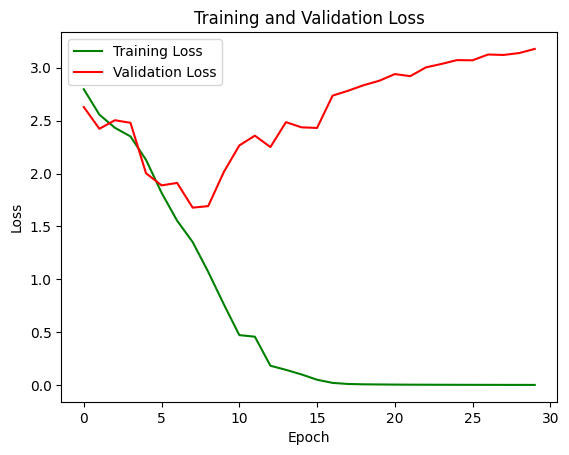

In [17]:
model = BaselineKernels()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.75)

training(model, loss_fn, optimizer, train_loader, val_loader, epochs=EPOCHS, name="kernel")

#### Training Baseline with different kernel size on augmented data

Epoch 1/30
Train Loss: 3.0129 - Validation Loss: 2.6558
Epoch 2/30
Train Loss: 2.6355 - Validation Loss: 2.5046
Epoch 3/30
Train Loss: 2.5133 - Validation Loss: 2.1230
Epoch 4/30
Train Loss: 2.4078 - Validation Loss: 1.9503
Epoch 5/30
Train Loss: 2.2735 - Validation Loss: 1.7650
Epoch 6/30
Train Loss: 2.0831 - Validation Loss: 1.6748
Epoch 7/30
Train Loss: 1.9406 - Validation Loss: 1.5361
Epoch 8/30
Train Loss: 1.8173 - Validation Loss: 1.2963
Epoch 9/30
Train Loss: 1.5956 - Validation Loss: 1.1836
Epoch 10/30
Train Loss: 1.5531 - Validation Loss: 1.2908
Epoch 11/30
Train Loss: 1.3563 - Validation Loss: 1.0257
Epoch 12/30
Train Loss: 1.2252 - Validation Loss: 1.0839
Epoch 13/30
Train Loss: 1.1578 - Validation Loss: 0.8968
Epoch 14/30
Train Loss: 0.9571 - Validation Loss: 0.8305
Epoch 15/30
Train Loss: 0.9421 - Validation Loss: 0.7370
Epoch 16/30
Train Loss: 0.7852 - Validation Loss: 0.7068
Epoch 17/30
Train Loss: 0.6660 - Validation Loss: 0.7110
Epoch 18/30
Train Loss: 0.5871 - Validat

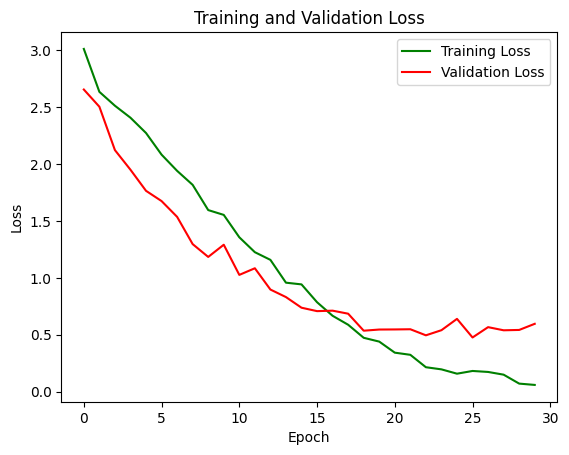

In [18]:
model = BaselineKernels()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.75)

training(model, loss_fn, optimizer, augmented_train_loader, val_loader, epochs=EPOCHS, name="augmentedKernel")

### Training Baseline using Adam optimizer

Epoch 1/30
Train Loss: 2.7101 - Validation Loss: 2.7086
Epoch 2/30
Train Loss: 2.6918 - Validation Loss: 2.6367
Epoch 3/30
Train Loss: 2.3894 - Validation Loss: 2.1974
Epoch 4/30
Train Loss: 1.9995 - Validation Loss: 2.1522
Epoch 5/30
Train Loss: 1.6508 - Validation Loss: 1.9135
Epoch 6/30
Train Loss: 1.2238 - Validation Loss: 2.1183
Epoch 7/30
Train Loss: 0.7777 - Validation Loss: 2.5153
Epoch 8/30
Train Loss: 0.3995 - Validation Loss: 2.6387
Epoch 9/30
Train Loss: 0.1737 - Validation Loss: 3.6168
Epoch 10/30
Train Loss: 0.0824 - Validation Loss: 4.1826
Epoch 11/30
Train Loss: 0.0448 - Validation Loss: 4.9905
Epoch 12/30
Train Loss: 0.0354 - Validation Loss: 4.5156
Epoch 13/30
Train Loss: 0.0165 - Validation Loss: 5.1308
Epoch 14/30
Train Loss: 0.0063 - Validation Loss: 5.2910
Epoch 15/30
Train Loss: 0.0054 - Validation Loss: 5.5893
Epoch 16/30
Train Loss: 0.0032 - Validation Loss: 5.5710
Epoch 17/30
Train Loss: 0.0023 - Validation Loss: 5.7220
Epoch 18/30
Train Loss: 0.0018 - Validat

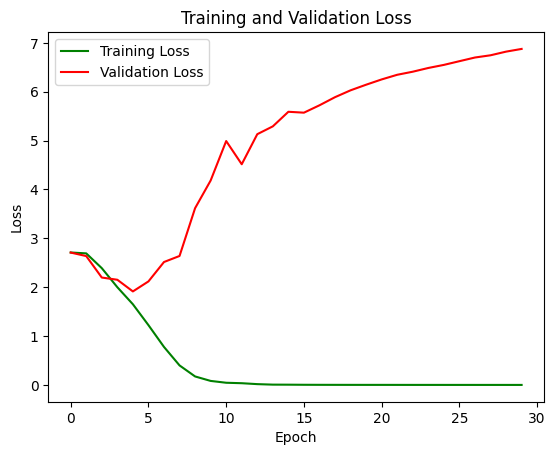

In [42]:
model = Baseline()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

training(model, loss_fn, optimizer, train_loader, val_loader, epochs=EPOCHS, name="adam")

#### Training Baseline using Adam optimizer on augmented data

Epoch 1/30
Train Loss: 2.7083 - Validation Loss: 2.6741
Epoch 2/30
Train Loss: 2.5775 - Validation Loss: 2.2615
Epoch 3/30
Train Loss: 2.1924 - Validation Loss: 1.8323
Epoch 4/30
Train Loss: 1.9362 - Validation Loss: 1.5461
Epoch 5/30
Train Loss: 1.7299 - Validation Loss: 1.5067
Epoch 6/30
Train Loss: 1.6083 - Validation Loss: 1.3081
Epoch 7/30
Train Loss: 1.4483 - Validation Loss: 1.1101
Epoch 8/30
Train Loss: 1.3006 - Validation Loss: 1.1461
Epoch 9/30
Train Loss: 1.1578 - Validation Loss: 0.9076
Epoch 10/30
Train Loss: 1.0323 - Validation Loss: 0.8890
Epoch 11/30
Train Loss: 0.8922 - Validation Loss: 0.7034
Epoch 12/30
Train Loss: 0.6890 - Validation Loss: 0.6665
Epoch 13/30
Train Loss: 0.6076 - Validation Loss: 0.5696
Epoch 14/30
Train Loss: 0.5112 - Validation Loss: 0.6324
Epoch 15/30
Train Loss: 0.4293 - Validation Loss: 0.5132
Epoch 16/30
Train Loss: 0.3019 - Validation Loss: 0.5447
Epoch 17/30
Train Loss: 0.2548 - Validation Loss: 0.5132
Epoch 18/30
Train Loss: 0.1976 - Validat

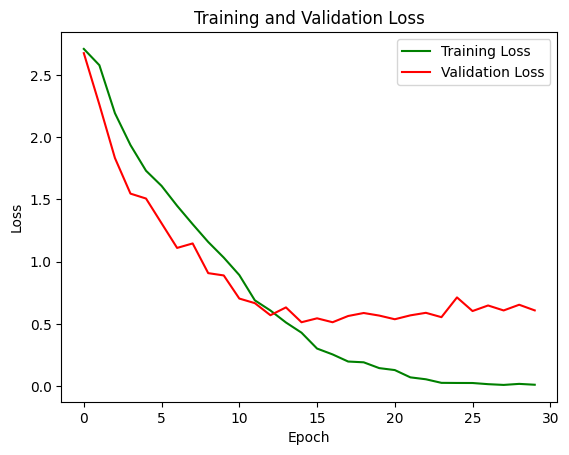

In [20]:
model = Baseline()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

training(model, loss_fn, optimizer, augmented_train_loader, val_loader, epochs=EPOCHS, name="augmentedAdam")

### Training Baseline with Dropout

Epoch 1/30
Train Loss: 2.7087 - Validation Loss: 2.7090
Epoch 2/30
Train Loss: 2.7078 - Validation Loss: 2.7096
Epoch 3/30
Train Loss: 2.7077 - Validation Loss: 2.7092
Epoch 4/30
Train Loss: 2.7060 - Validation Loss: 2.7100
Epoch 5/30
Train Loss: 2.7066 - Validation Loss: 2.7076
Epoch 6/30
Train Loss: 2.7066 - Validation Loss: 2.7021
Epoch 7/30
Train Loss: 2.7021 - Validation Loss: 2.6886
Epoch 8/30
Train Loss: 2.6982 - Validation Loss: 2.6680
Epoch 9/30
Train Loss: 2.6912 - Validation Loss: 2.6704
Epoch 10/30
Train Loss: 2.6762 - Validation Loss: 2.6618
Epoch 11/30
Train Loss: 2.6739 - Validation Loss: 2.5736
Epoch 12/30
Train Loss: 2.6311 - Validation Loss: 2.4240
Epoch 13/30
Train Loss: 2.5856 - Validation Loss: 2.3879
Epoch 14/30
Train Loss: 2.5109 - Validation Loss: 2.2877
Epoch 15/30
Train Loss: 2.4522 - Validation Loss: 2.1456
Epoch 16/30
Train Loss: 2.3051 - Validation Loss: 2.0463
Epoch 17/30
Train Loss: 2.2227 - Validation Loss: 1.9778
Epoch 18/30
Train Loss: 2.1736 - Validat

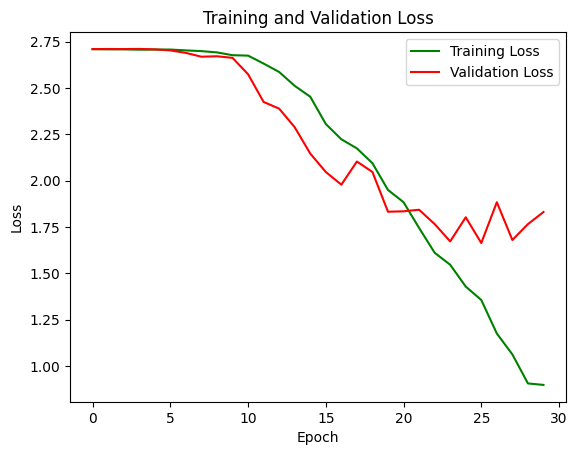

In [46]:
model = BaselineDropout()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.75)

training(model, loss_fn, optimizer,train_loader, val_loader, epochs=EPOCHS, name="dropout")

#### Training Baseline with Dropout on augmented data

Epoch 1/30
Train Loss: 2.7082 - Validation Loss: 2.7062
Epoch 2/30
Train Loss: 2.7071 - Validation Loss: 2.7023
Epoch 3/30
Train Loss: 2.7063 - Validation Loss: 2.6951
Epoch 4/30
Train Loss: 2.7054 - Validation Loss: 2.6847
Epoch 5/30
Train Loss: 2.7012 - Validation Loss: 2.6824
Epoch 6/30
Train Loss: 2.6917 - Validation Loss: 2.6092
Epoch 7/30
Train Loss: 2.6864 - Validation Loss: 2.5998
Epoch 8/30
Train Loss: 2.6797 - Validation Loss: 2.6151
Epoch 9/30
Train Loss: 2.6652 - Validation Loss: 2.4604
Epoch 10/30
Train Loss: 2.6501 - Validation Loss: 2.4395
Epoch 11/30
Train Loss: 2.6221 - Validation Loss: 2.4072
Epoch 12/30
Train Loss: 2.5822 - Validation Loss: 2.2756
Epoch 13/30
Train Loss: 2.5314 - Validation Loss: 2.1957
Epoch 14/30
Train Loss: 2.4788 - Validation Loss: 2.1166
Epoch 15/30
Train Loss: 2.4004 - Validation Loss: 1.9849
Epoch 16/30
Train Loss: 2.4395 - Validation Loss: 2.1262
Epoch 17/30
Train Loss: 2.3373 - Validation Loss: 2.0833
Epoch 18/30
Train Loss: 2.2717 - Validat

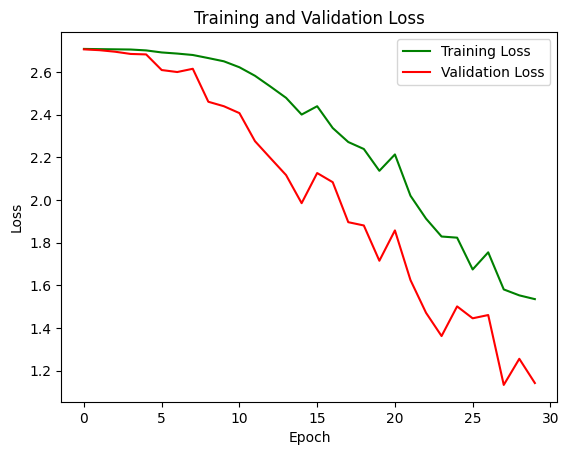

In [47]:
model = BaselineDropout()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.75)

training(model, loss_fn, optimizer, augmented_train_loader, val_loader, epochs=EPOCHS, name="augmentedDropout")

## Testing

### Testing Baseline model

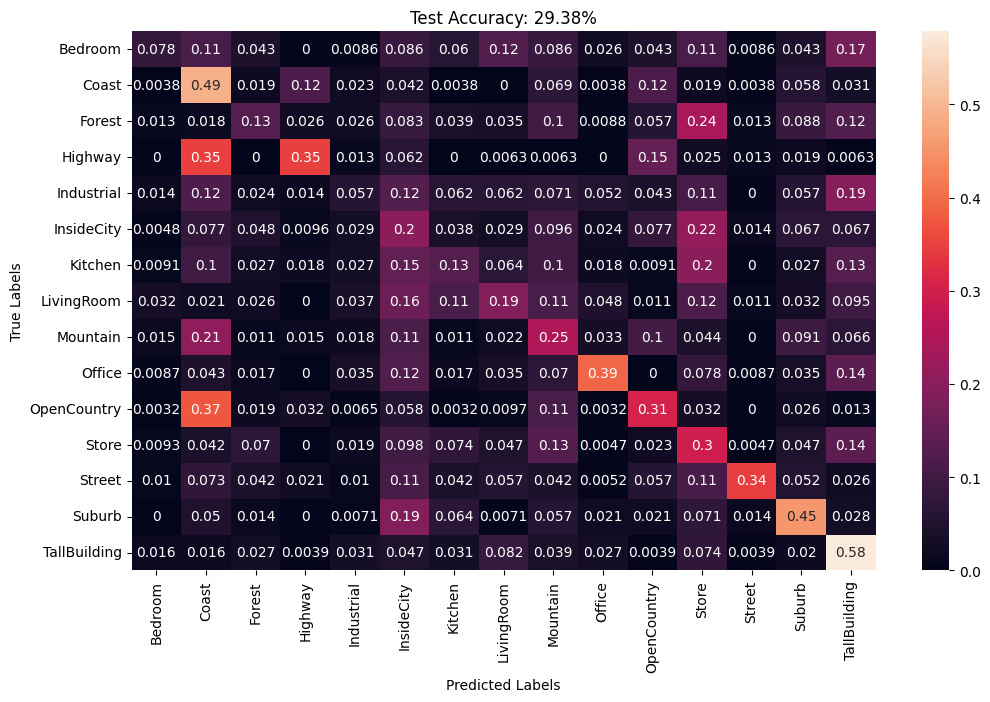

In [20]:
model = Baseline()
model.load_state_dict(torch.load("./models/baseline.pth", weights_only=True))
test(model, test_loader)

#### Testing Augmented Baseline Model

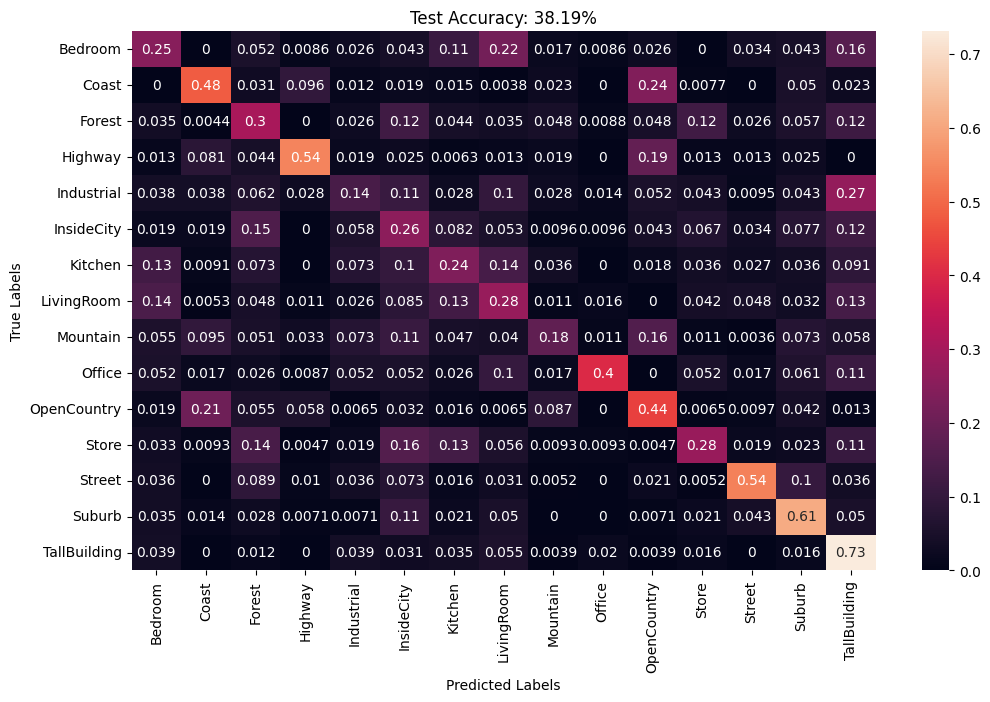

In [21]:
model = Baseline()
model.load_state_dict(torch.load("./models/augmentedBaseline.pth", weights_only=True))
test(model, test_loader)

### Testing Baseline with Batch Normalization

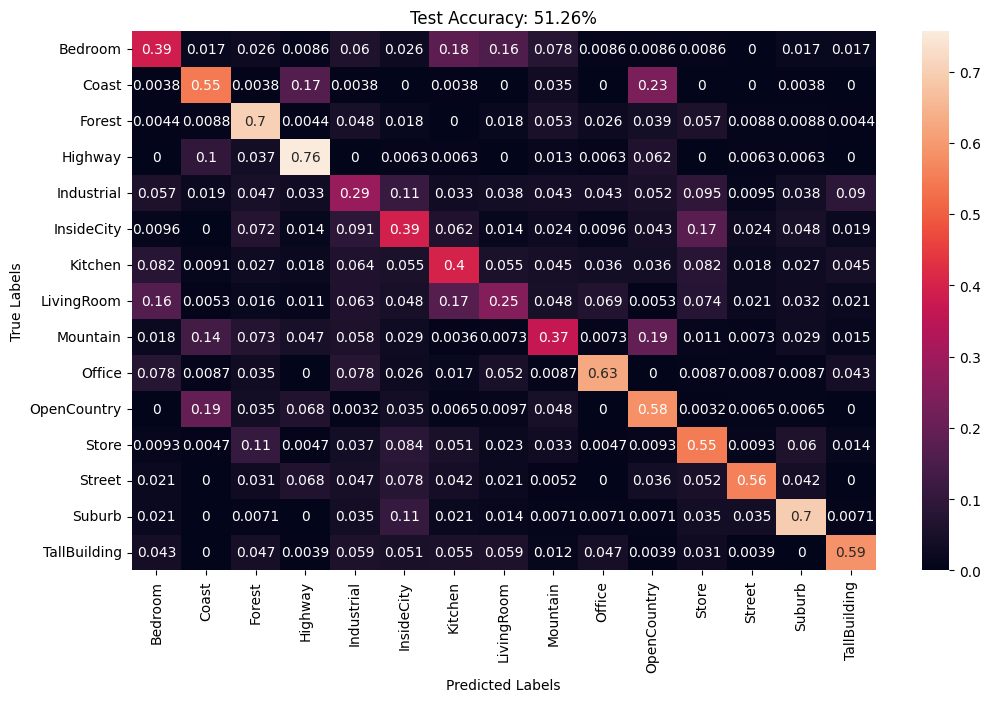

In [22]:
model = BaselineBatch()
model.load_state_dict(torch.load("./models/batch.pth", weights_only=True))
test(model, test_loader)

#### Testing Augmented Batch Normalization Model

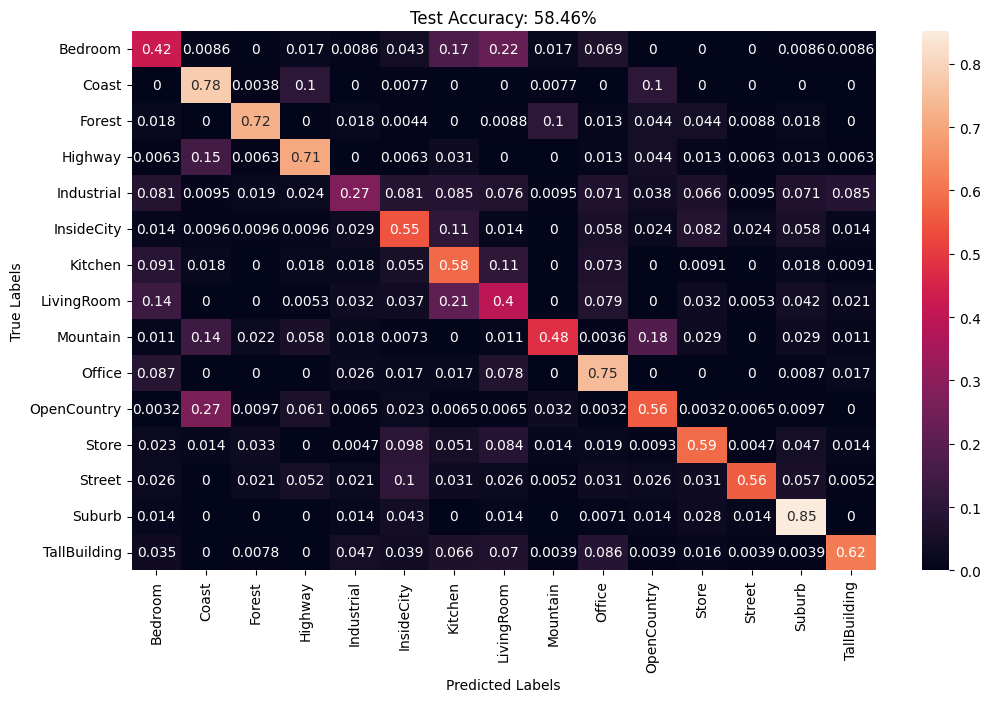

In [23]:
model = BaselineBatch()
model.load_state_dict(torch.load("./models/augmentedBatch.pth", weights_only=True))
test(model, test_loader)

### Testing Baseline with different kernel size

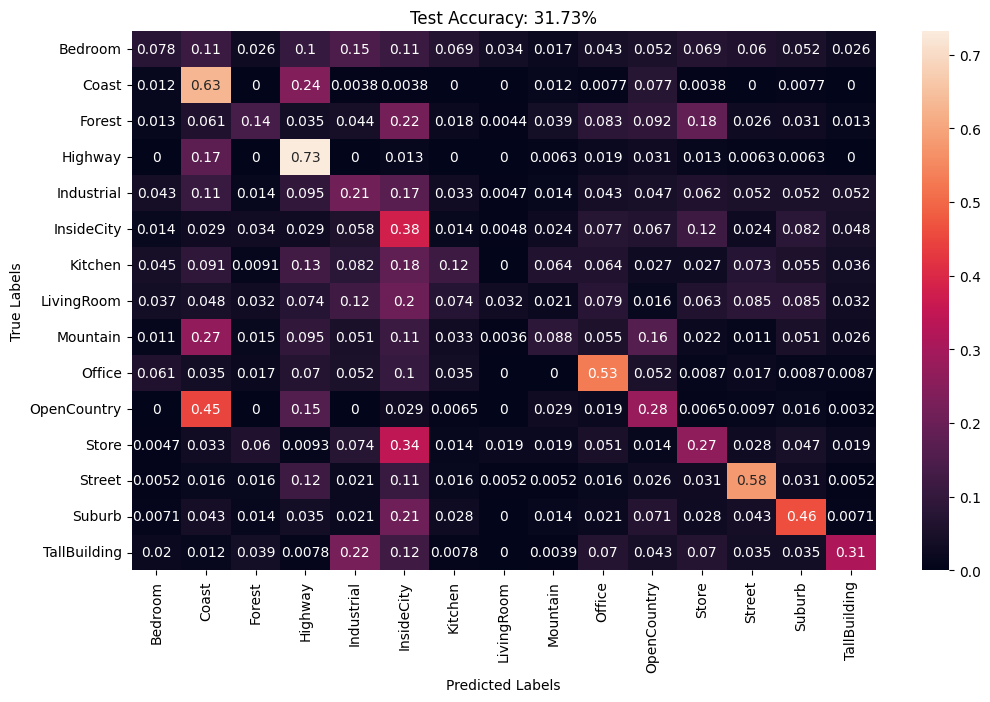

In [24]:
model = BaselineKernels()
model.load_state_dict(torch.load("./models/kernel.pth", weights_only=True))
test(model, test_loader)

#### Testing Augmented Kernel Size Model

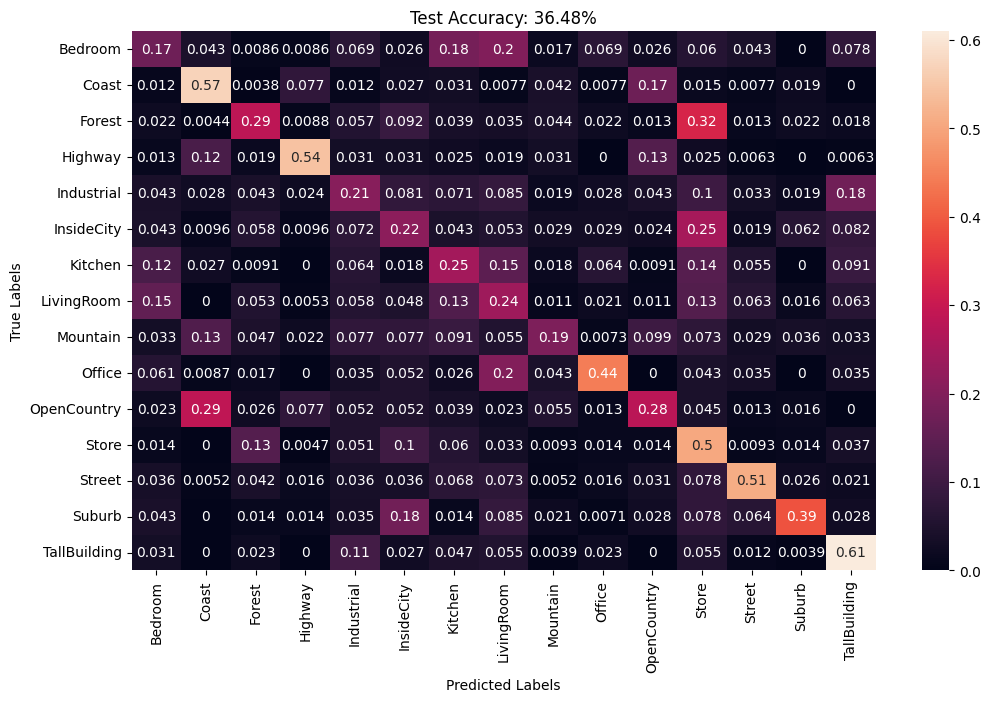

In [25]:
model = BaselineKernels()
model.load_state_dict(torch.load("./models/augmentedKernel.pth", weights_only=True))
test(model, test_loader)

### Testing Baseline using Adam optimizer

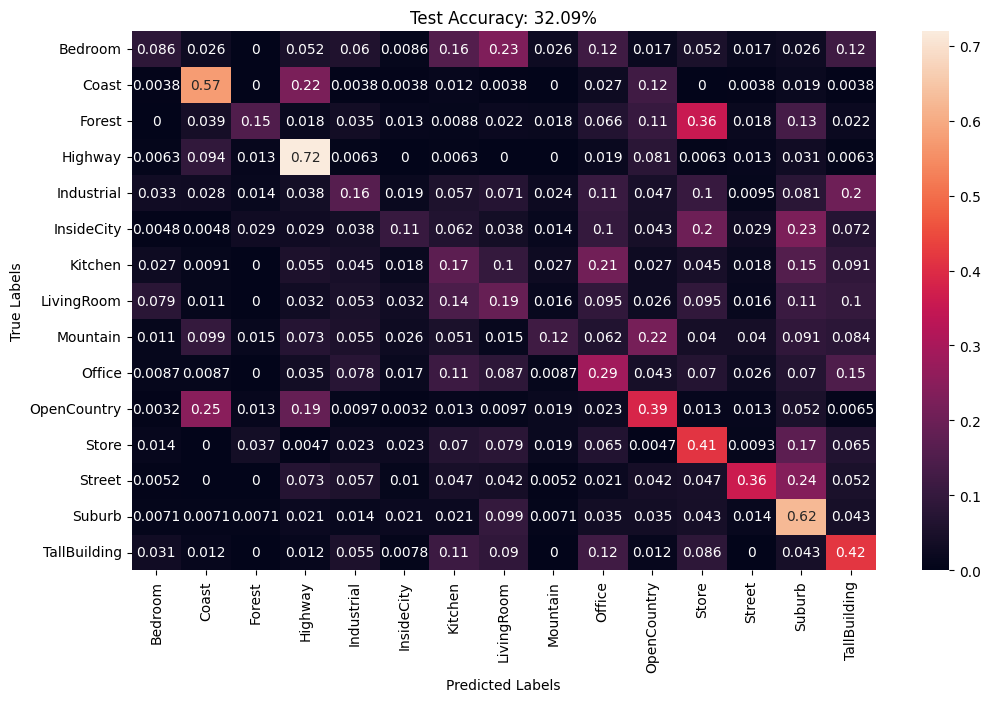

In [26]:
model = Baseline()
model.load_state_dict(torch.load("./models/adam.pth", weights_only=True))
test(model, test_loader)

#### Testing Augmented Adam optimizer Model

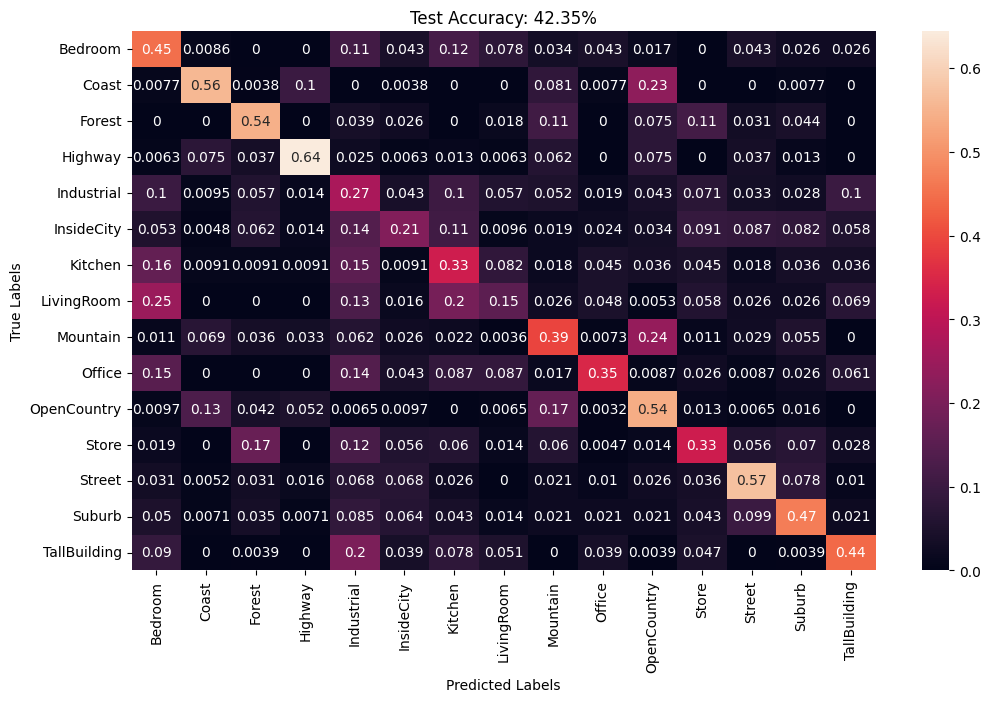

In [27]:
model = Baseline()
model.load_state_dict(torch.load("./models/augmentedAdam.pth", weights_only=True))
test(model, test_loader)

### Testing Baseline with Dropout

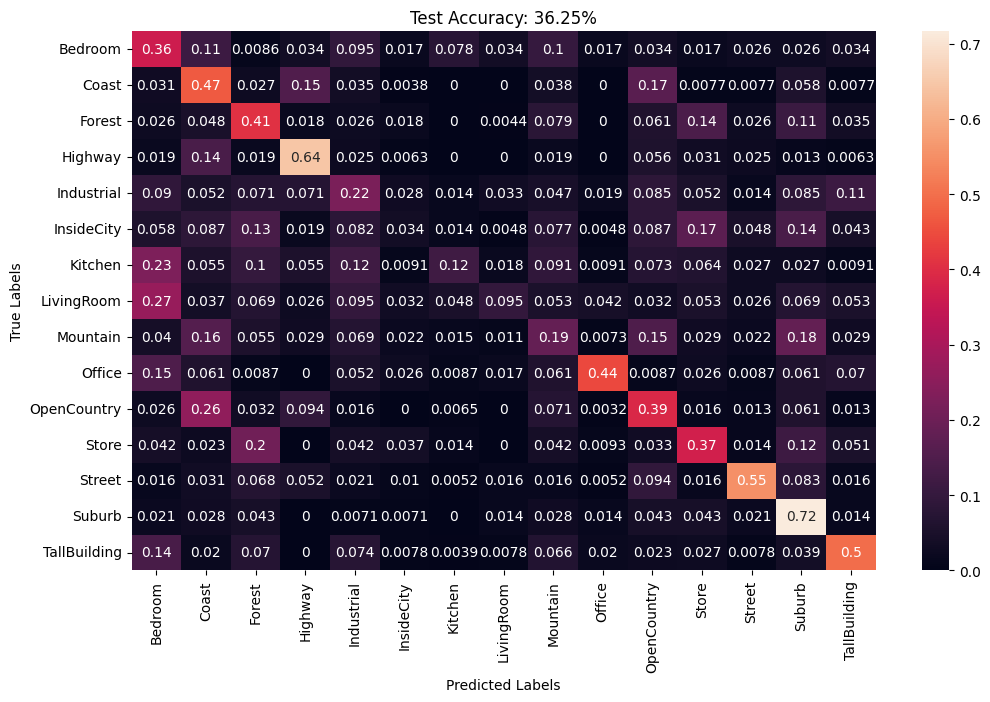

In [48]:
model = BaselineDropout()
model.load_state_dict(torch.load("./models/dropout.pth", weights_only=True))
test(model, test_loader)

#### Testing Augmented Dropout Model

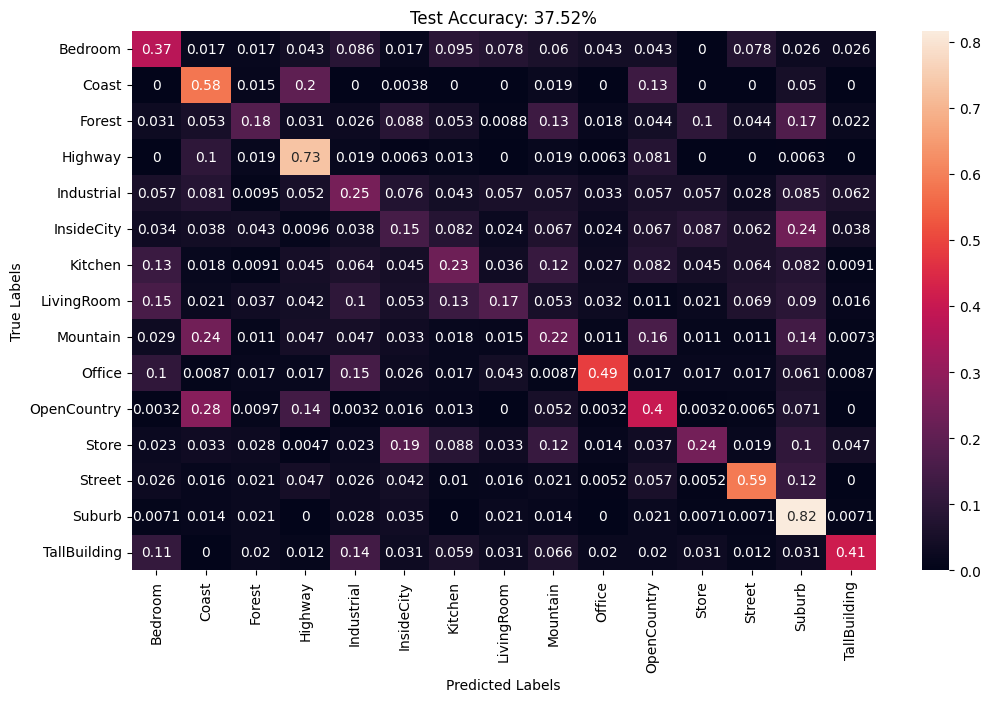

In [49]:
model = BaselineDropout()
model.load_state_dict(torch.load("./models/augmentedDropout.pth", weights_only=True))
test(model, test_loader)

### Testing Ensemble of Network

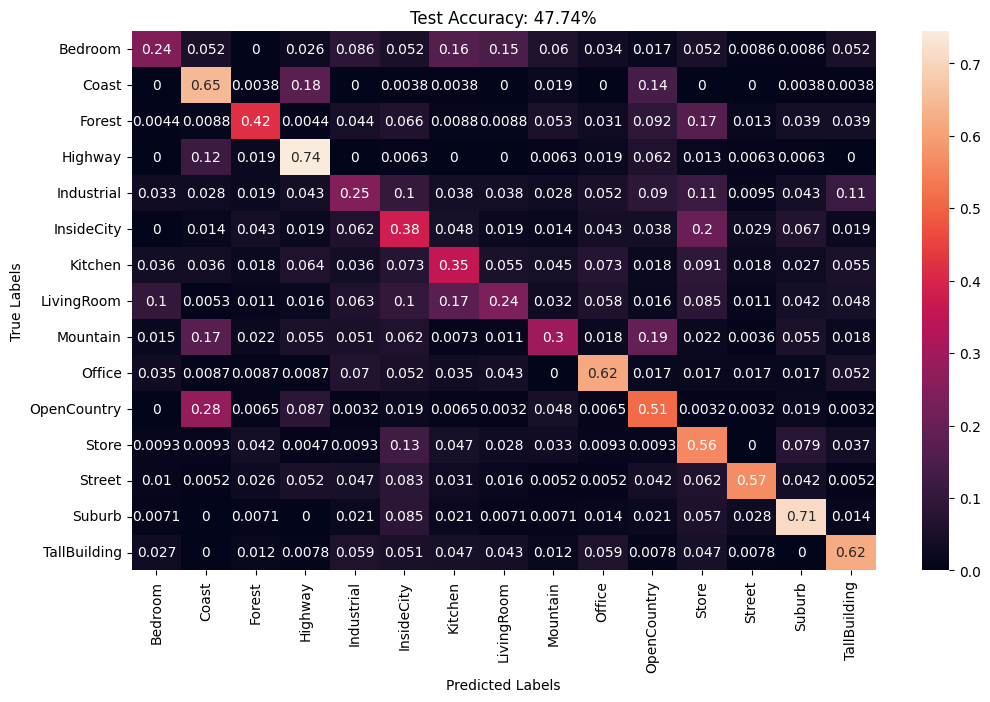

In [30]:
baseline = Baseline()
baseline.load_state_dict(torch.load("./models/baseline.pth", weights_only=True))
batch = BaselineBatch()
batch.load_state_dict(torch.load("./models/batch.pth", weights_only=True))
kernel = BaselineKernels()
kernel.load_state_dict(torch.load("./models/kernel.pth", weights_only=True))
adam = Baseline()
adam.load_state_dict(torch.load("./models/adam.pth", weights_only=True))
dropout = BaselineDropout()
dropout.load_state_dict(torch.load("./models/dropout.pth", weights_only=True))

models = [ baseline, batch, kernel, adam, dropout]

test_ensemble(models, test_loader)

#### Testing Augmented Ensemble Model

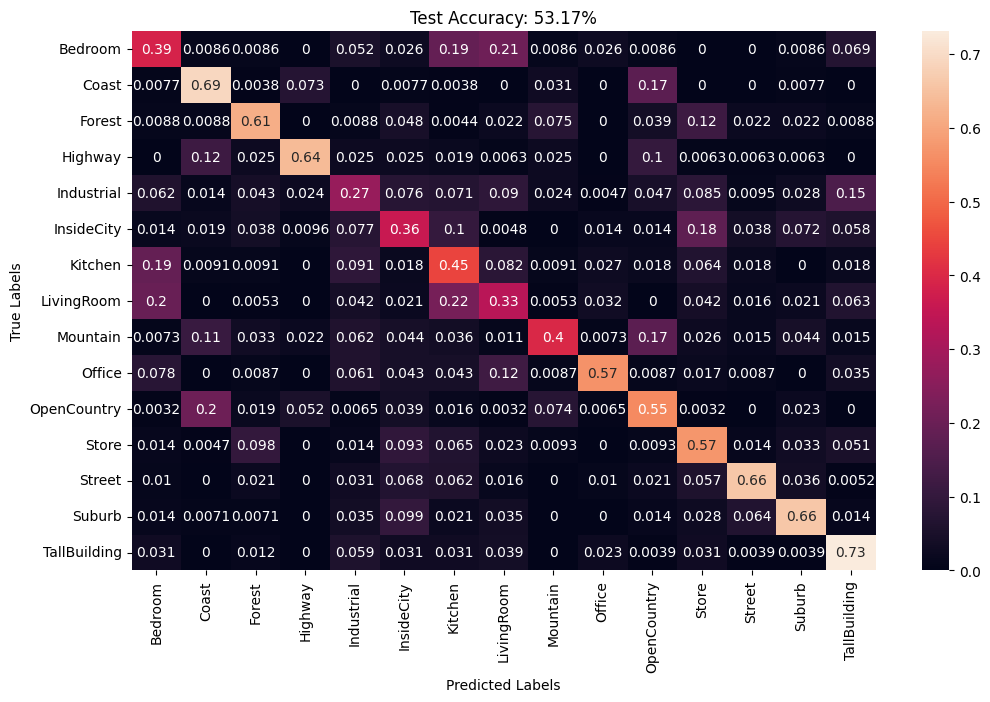

In [31]:
baseline = Baseline()
baseline.load_state_dict(torch.load("./models/augmentedBaseline.pth", weights_only=True))
batch = BaselineBatch()
batch.load_state_dict(torch.load("./models/augmentedBatch.pth", weights_only=True))
kernel = BaselineKernels()
kernel.load_state_dict(torch.load("./models/augmentedKernel.pth", weights_only=True))
adam = Baseline()
adam.load_state_dict(torch.load("./models/augmentedAdam.pth", weights_only=True))
dropout = BaselineDropout()
dropout.load_state_dict(torch.load("./models/augmentedDropout.pth", weights_only=True))

models = [ baseline, batch, kernel, adam, dropout]

test_ensemble(models, test_loader)

# Transfer Learning

## Using AlexNet

In [32]:
alexnet_transforms_pipeline = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

alexnet_train_dataset = datasets.ImageFolder("./dataset/train", transform=alexnet_transforms_pipeline)

alexnet_test_dataset = datasets.ImageFolder("./dataset/test", transform=alexnet_transforms_pipeline)

alexnet_train_dataset,  alexnet_val_dataset = random_split(alexnet_train_dataset, [int(len(alexnet_train_dataset)*0.85), int(len(alexnet_train_dataset)*0.15)])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

alexnet_train_loader = DataLoader(alexnet_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
alexnet_val_loader = DataLoader(alexnet_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
alexnet_test_loader = DataLoader(alexnet_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

alexnet_model = alexnet(weights=AlexNet_Weights.DEFAULT)
print(alexnet_model)

Train dataset size: 1275
Validation dataset size: 225
Test dataset size: 2985
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, in

### Freezing the weights of all layers except the last fully connected

In [33]:
for param in alexnet_model.parameters():
    param.requires_grad = False

alexnet_model.classifier[6] = nn.Linear(in_features=4096, out_features=15)

### Training freezed AlexNet

Epoch 1/30
Train Loss: 1.4537 - Validation Loss: 0.8332
Epoch 2/30
Train Loss: 0.6405 - Validation Loss: 0.5752
Epoch 3/30
Train Loss: 0.4913 - Validation Loss: 0.5292
Epoch 4/30
Train Loss: 0.4241 - Validation Loss: 0.4886
Epoch 5/30
Train Loss: 0.3729 - Validation Loss: 0.4875
Epoch 6/30
Train Loss: 0.3310 - Validation Loss: 0.4372
Epoch 7/30
Train Loss: 0.3126 - Validation Loss: 0.4538
Epoch 8/30
Train Loss: 0.2770 - Validation Loss: 0.4262
Epoch 9/30
Train Loss: 0.2570 - Validation Loss: 0.4270
Epoch 10/30
Train Loss: 0.2394 - Validation Loss: 0.4034
Epoch 11/30
Train Loss: 0.2335 - Validation Loss: 0.4057
Epoch 12/30
Train Loss: 0.2229 - Validation Loss: 0.3914
Epoch 13/30
Train Loss: 0.2114 - Validation Loss: 0.3909
Epoch 14/30
Train Loss: 0.2044 - Validation Loss: 0.3958
Epoch 15/30
Train Loss: 0.1987 - Validation Loss: 0.3860
Epoch 16/30
Train Loss: 0.1927 - Validation Loss: 0.3873
Epoch 17/30
Train Loss: 0.1836 - Validation Loss: 0.3936
Epoch 18/30
Train Loss: 0.1700 - Validat

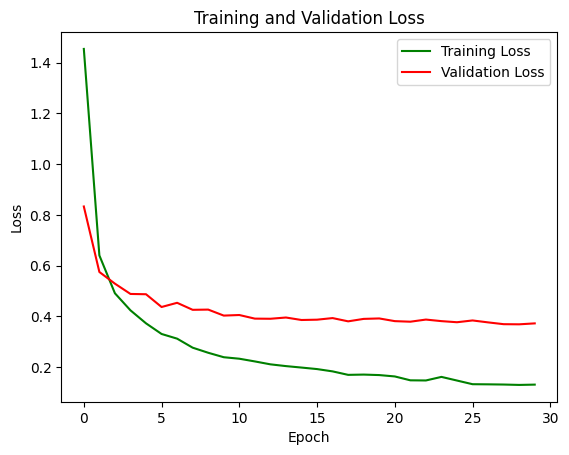

In [37]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet_model.parameters(), lr=0.001, momentum=0.75)
training(alexnet_model, loss_fn, optimizer, alexnet_train_loader, alexnet_val_loader, epochs=EPOCHS, name="alexnet")

### Testing Freezed AlexNet

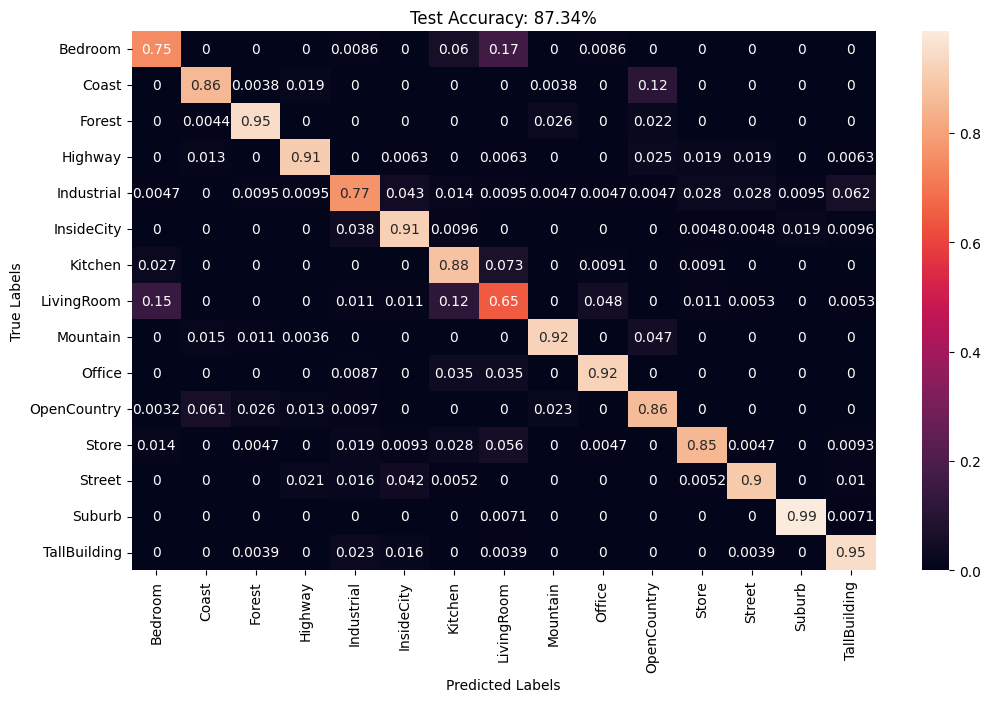

In [34]:
alexnet_model.load_state_dict(torch.load("./models/alexnet.pth", weights_only=True))
test(alexnet_model, alexnet_test_loader)

## AlexNet as Feature Extractor

### Define Feature Extractor

In [35]:
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(model.children())[:-1]) # All layers except classifier
        self.fc = nn.Linear(in_features=9216, out_features=4096)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 9216)
        x = self.fc(x)
        x = self.relu(x)
        return x

### Extract Features from Dataset using AlexNet

In [36]:

def extract_features(model, data_loader):
    features = []
    labels = []
    model.eval()
    with torch.no_grad():
        for (input, label) in data_loader:
            output = model(input)
            features.append(output)
            labels.append(label)
    
    features = torch.cat(features).numpy()
    labels = torch.cat(labels).numpy()
    return features, labels

alexnet_model = alexnet(weights=AlexNet_Weights.DEFAULT)
feature_extractor = FeatureExtractor(alexnet_model)

train_features, train_labels = extract_features(feature_extractor, alexnet_train_loader)
test_features, test_labels = extract_features(feature_extractor, alexnet_test_loader)

### Training & Testing Multiclass SVM

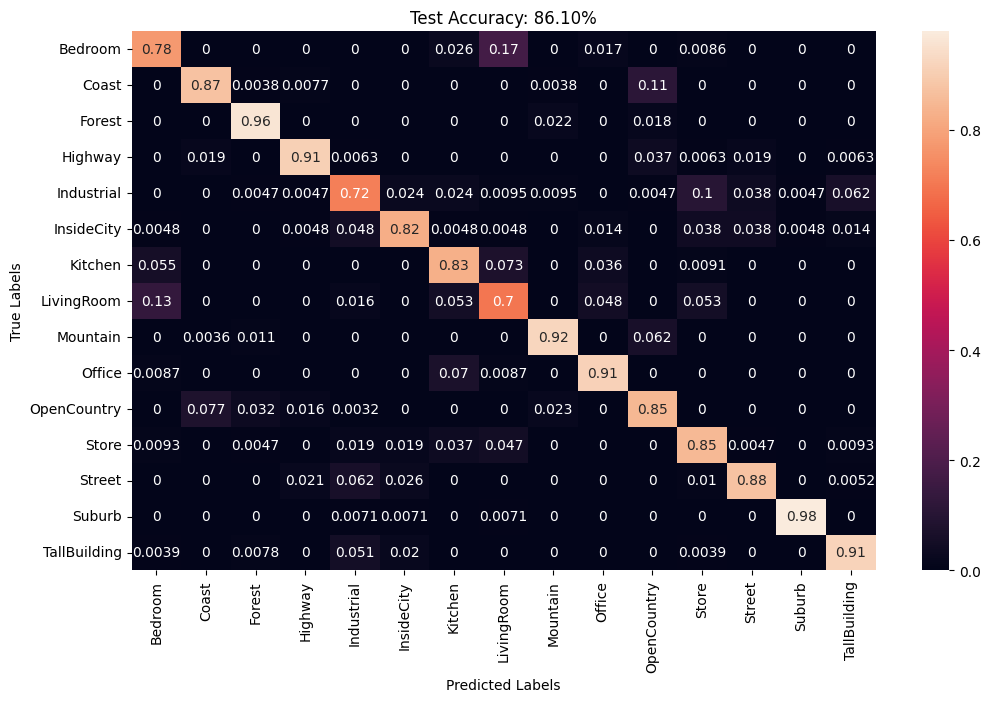

In [37]:
svm = make_pipeline(StandardScaler(), SVC(kernel='linear', decision_function_shape='ovr'))
svm.fit(train_features, train_labels)

#evaluate the model
y_pred = svm.predict(test_features)
accuracy = accuracy_score(test_labels, y_pred)
cm = confusion_matrix(test_labels, y_pred)
df_cm = pd.DataFrame(cm / np.sum(cm, axis=1)[:, None], index = [labelsMap[i] for i in range(15)], columns = [labelsMap[i] for i in range(15)])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f"Test Accuracy: {accuracy*100:.2f}%")
plt.show()